**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

---
## **Trabajo práctico entregable - Parte 2**
---

## **Grupo 20**

**Integrantes:** Fanny Ruales, Gastón Briozzo, Jonatan Garnier, Laura Velazquez, Tomás Niño Kehoe

**Profesor de Práctico:** Alejandro García

# Importación de librerias y lectura del dataset

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import scipy.stats

from scipy import stats
from scipy.stats import t

seaborn.set_context('talk')

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [3]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,...,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,...,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,...,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,...,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


In [4]:
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                     \
                             count          mean            std   min   
profile_gender                                                          
Hombre                      4944.0  98836.063558  102159.664237   1.0   
Mujer                        908.0  73501.414465   56256.880181   2.0   
Otros                         31.0  95441.354839   88635.674358  40.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          53285.0  80000.0  110000.0  2080000.0  
Mujer           43818.0  65000.0   92000.0   800000.0  
Otros           39500.0  74000.0  117500.0   380000.0

In [5]:
df[df.salary_monthly_NETO > 1000]\
  [['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                         \
                             count           mean            std      min   
profile_gender                                                              
Hombre                      4815.0  101481.624343  102215.304684   1100.0   
Mujer                        863.0   77328.913778   55082.760570   2000.0   
Otros                         28.0  105660.714286   87235.710235  34000.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          55000.0  80000.0  110000.0  2080000.0  
Mujer           47850.0  67200.0   93000.0   800000.0  
Otros           43750.0  78900.0  122750.0   380000.0

In [6]:
alpha = 0.05

In [7]:
is_man = df.profile_gender == 'Hombre'

groupA = df[(df.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
groupB = df[(df.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO

# Corrección: Eliminación de Outliers

El salario mínimo, vital y móvil en Argentina fue de $20.587,5 en diciembre del 2020 (año de recolección de los datos). Dado que estamos interesados en empleos formales, eliminaremos los datos por debajo de esta cifra. 

In [8]:
smn_min = 20587.5

Por otro lado, hay sueldos sospechosamente elevados, por lo que conservaremos solamente los datos hasta el cuantil 0.99, es decir, los datos con un nivel de significancia mayor al 1%.



In [9]:
smn_max = df.salary_monthly_NETO.quantile(0.99)

In [10]:
groupA = df[(smn_min < df.salary_monthly_NETO) & (df.salary_monthly_NETO < smn_max) &  is_man].salary_monthly_NETO
groupB = df[(smn_min < df.salary_monthly_NETO) & (df.salary_monthly_NETO < smn_max) & ~is_man].salary_monthly_NETO

De esta forma, hemos eliminado los outliers del sueldo.

# Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

## Cálculo y Desarrollo - Corregido por Test de Welch

Para empezar, verifiquemos que los salarios tengan distribuciones estadísticas

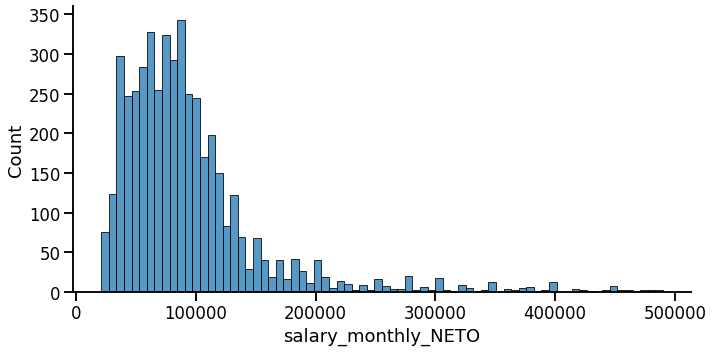

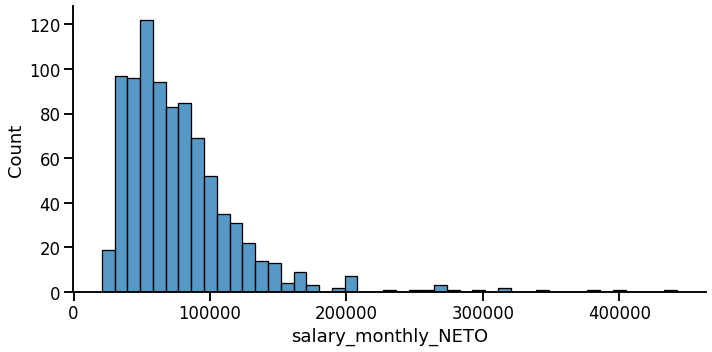

In [11]:
seaborn.displot(groupA, aspect=2)
seaborn.displot(groupB, aspect=2)

Ahora, lo que sabemos es que la distribución

$ T=\frac{\left(\overline{\mu_H}-\overline{\mu_M}\right) - \left(\mu_H-\mu_M \right)}{S} $,

donde 

$S=\sqrt{\frac{S_1^2}{n_1}+\frac{S_2^2}{n_2}}$,

es una t de Student con

$ν=\frac{\left(\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}\right)^2}{\frac{S_1^4}{n_1^2ν_1} + \frac{S_2^4}{n_2^2ν_2}}$.

grados de libertad, según lo indica el [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html).


Ahora, definamos algunos valores

In [12]:
mu_a    = groupA.mean() # Media del grupo A
mu_b    = groupB.mean() # Media del grupo B
n_a     = len(groupA)   # Cantidad de datos del grupo A
n_b     = len(groupB)   # Cantidad de datos del grupo B
var_a   = groupA.var()  # Varianza del grupo A
var_b   = groupB.var()  # Varianza del grupo B

s_welch = np.sqrt(var_a/n_a + var_b/n_b)                                                    # Desviación estándar de Welch
n_welch = int(np.floor( s_welch**4/( var_a**2/n_a**2/(n_a-1) + var_b**2/n_b**2/(n_b-1) ) )) # Grados de libertad

Veamos cuantos grados de libertad tenemos

In [13]:
print(n_a, n_b, n_a+n_b-2)

4681 871 5550


Para esta cantidad de grados de libertad, la t de Student es prácticamente indistinguible de una Gaussiana, por lo que podemos considerar que sus distribuciones son idénticas. De todas formas, tomaremos en consideración los grados de libertad correspondientes al Test de Welch.

In [14]:
print(n_welch)

1581


Para un nivel de confianza de $1-\alpha$, siendo $\alpha$ la significancia, se tiene que la probabilidad de que el valor real del estadístico se encuentre entre el valor obtenido menos $t_{\alpha/2}$ y el valor obtenido mas $t_{\alpha/2}$ es $1-\alpha$. Es decir:

$P\left( -t_{α/2} \leq T \leq t_{α/2} \right) = 1-α$

Dada la expresión encontrada anteriormente para $T$, esto puede traducirse a la siguiente expresión:

$P\left( (μa−μb) - S ⋅ t_{α/2,ν}\leq \left(\overline{groupA}-\overline{groupB}\right) \leq (μa−μb) + S ⋅ t_{α/2,ν} \right) = 1-α$

donde $(μa−μb) - S ⋅ t_{α/2,ν}$ y $(μa−μb) + S ⋅ t_{α/2,ν}$ son, respectivamente, los límites inferior y superior del intervalo de confianza para $\overline{groupA}-\overline{groupB}$, con nivel de significancia $α$.

Pasamos a calcular el intervalo de confianza de nuestra distribución dada la significancia $α$

In [15]:
alpha = 0.05                                             # Significancia sugerida
media = mu_a-mu_b                                        # Estadístico obtenido
t_welch = t.ppf(1-alpha/2, n_welch, loc = 0, scale = 1)  # Coeficiente t de Student

lim_inf = media - s_welch*t_welch
lim_sup = media + s_welch*t_welch

print('Nivel de confianza:                                 ', 1-alpha)
print('Nivel de significancia:                             ', alpha)
print('Diferencia entre las medias de ambas distribuciones:', media)
print('Limite inferior del intervalo de confianza:         ', lim_inf)
print('Limite superior del intervalo de confianza:         ', lim_sup)
print('Longitud del intervalo de confianza:                 ', lim_sup-lim_inf)

Nivel de confianza:                                  0.95
Nivel de significancia:                              0.05
Diferencia entre las medias de ambas distribuciones: 16929.739954946504
Limite inferior del intervalo de confianza:          13404.254105178748
Limite superior del intervalo de confianza:          20455.22580471426
Longitud del intervalo de confianza:                  7050.971699535512


## Resultados

In [16]:
print('Nivel de confianza:                                 ', 1-alpha)
print('Nivel de significancia:                             ', alpha)
print('Diferencia entre las medias de ambas distribuciones:', media)
print('Limite inferior del intervalo de confianza:         ', lim_inf)
print('Limite superior del intervalo de confianza:         ', lim_sup)
print('Longitud del intervalo de confianza:                 ', lim_sup-lim_inf)

Nivel de confianza:                                  0.95
Nivel de significancia:                              0.05
Diferencia entre las medias de ambas distribuciones: 16929.739954946504
Limite inferior del intervalo de confianza:          13404.254105178748
Limite superior del intervalo de confianza:          20455.22580471426
Longitud del intervalo de confianza:                  7050.971699535512


**¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?**

La hipótesis nula será aceptada (con un nivel de significancia $α$) en caso de que el valor medio supuesto para la distribución este contenido dentro del intervalo de confianza. En caso contrario, la hipótesis nula será descartada.

# Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

$H_0=...$

**Estadístico (Pivote)**
  * Identificar el estadístico
  * Escribir qué distribución tiene bajo $H_0$


####2.1.1 Hipótesis Nula $H_0$

Es la hipótesis que se considera verdadera por defecto. En este caso, que la media del salario neto de hombres $\overline{\mu_H}$ es igual a la media del salario neto de los demas géneros $\overline{\mu_M}$.

$H_0: \mu_H=\mu_M → T_0=0$

####2.1.2 Hipótesis Alternativa $H_a$

Es una hipótesis que, en principio, no es compatible con la hipótesis nula. En este caso, que la media del salario neto de hombres $\overline{\mu_H}$ es mayor a la media del salario neto de los demas géneros $\overline{\mu_M}$.

$H_0: \mu_H>\mu_M → T_a>0$

####2.1.3 Estadístico de Prueba

Es una **Variable Aleatoria** obtenida de la muestra, que permitirá estudiar la veracidad o falsedad de las hipótesis nula y alternativa. Generalmente, se busca expresarla en terminos de una distribución conocida y normalizada, ya tabuladas, como una distribución normal (gaussiana) o una t de Student.

$ T=\frac{\left(\overline{\mu_H}-\overline{\mu_M}\right) - \left(\mu_H-\mu_M \right)}{S} $

es una t de Student con $ν$ grados de libertad, siendo

$S=\sqrt{\frac{S_1^2}{n_1}+\frac{S_2^2}{n_2}}$,

$ν=\frac{\left(\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}\right)^2}{\frac{S_1^4}{n_1^2ν_1} + \frac{S_2^4}{n_2^2ν_2}}$.

En este caso, el estadístico de prueva resulta

In [17]:
T = media/s_welch
print('T =',T)

T = 9.419156391720248


####2.1.4 Región de Rechazo

Definamos primero el intervalo de confianza:

Es una región al rededor de nuestro estadístico de prueva $T$ donde, con una probabilidad $(1-α)$, esperamos encontrar el valor estimado $T_0$, en caso de ser verdadera la hipótesis nula $H_0$. Aquí, $α$ es el nivel de significancia del intervalo. 

La región de rechazo es la región complementaria al intervalo de confianza. En caso de que nuestro estadístico de prueva $T$ se encuentre dentro de este intervalo, la hipótesis nula $H_0$ debe rechazarse, en favor de alguna hipotesis alternativa $H_a$. 

**Que $H_0$ deba descartarse no significa que $H_a$ deba ser aceptada**.

$RR=(-∞,-t_{α/2})𝖴(t_{α/2},∞)$

En este caso, con $α=0.05$, la región de rechazo resulta

In [18]:
t_str = str(t_welch)[:4]
t_str

'1.96'

$RR=(-∞,-1.96)𝖴(1.96,∞)$

### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

#### 2.2.1 Calcule el p-valor y decida si rechazar o no la hipótesis nula.

El p-valor de un estadístico de prueva, o *nivel de significancia alcanzado*, es el nivel de significancia $α$ mas pequeño para el cual la información observada indica que la hipótesis nula $H_0$ debe ser rechazada

In [19]:
t_welch = scipy.stats.ttest_ind(groupA, groupB, equal_var=False)[0]
p_welch = scipy.stats.ttest_ind(groupA, groupB, equal_var=False)[1]

print('P_valor:', p_welch)

print('El p-valor de nuestro test es', p_welch)

P_valor: 1.550951524452628e-20
El p-valor de nuestro test es 1.550951524452628e-20


Como se puede ver, el p-valor obtenido es mucho mas pequeño que el nivel de significancia propuesto, $α=0.05$, por lo que estamos en condiciones de rechazar la hipótesis nula $H_0:\mu_H=\mu_M$.

**LA HIPOTESIS NULA ES RECHAZADA**

Nota: Puede verse que el estadístico de prueba $T$ se corresponde al coeficiente $t_{p-val}$ de la t de Student con $ν$ grados de libertad

In [20]:
t_p = t.ppf(1-p_welch/2, n_welch, loc = 0, scale = 1)
print(T,t_p)

9.419156391720248 inf


Notar que aquí vemos un error numérico originado por trabajar con números muy cercanos a cero, en este caso, $p_{val} ≈ 10^{-20}$.

####2.2.2 Interprete el resultado.

##### Discusión

Despues de rechazar la hipótesis nula $H_0:\mu_H=\mu_M$, uno podría pensar que se tienen mas probabilidades de ganar un mejor salario siendo hombre que identificandosé con otro género. Sin embargo, esta conclusión es apresurada. Veamos por que.

Para empezar, la media sola da poca información respecto a las propiedades estadísticas de una población. Si, por ejemplo, en vez de usar como estimador la diferencia entre medias hubisemos empleado las medianas, obtendríamos mas información sobre las poblaciones

In [21]:
print('Mediana del genero    HOMBRES:', groupA.median())
print('Mediana del genero NO HOMBRES:', groupB.median())

Mediana del genero    HOMBRES: 80000.0
Mediana del genero NO HOMBRES: 68000.0


Vemos que la diferencia entre medianas apoya la hipótesis de que existen mejores posibilidades salariales siendo hombre que identificandose con otro género. 

Otro estimador que podriamos emplear para comparar ambas poblaciónes es la dispersión de estas (es decir, la desviación estándar)

In [22]:
print('Dispersión del genero    HOMBRES:', groupA.std())
print('Dispersión del genero NO HOMBRES:', groupB.std())

Dispersión del genero    HOMBRES: 63573.34794750803
Dispersión del genero NO HOMBRES: 45406.92837076626


Comparando las dispersiones, vemos que el género hombre tiene valores mucho mas alejados entre si que los demás géneros.

##### Conclusión

Podemos concluir que las distribuciones salariales del genero hombre tienen mayores media y mediana que la del género no hombres, presentando tambien una mayor desviación estándar.

Esto significa que los hombres, en promedio, ganan mejores salarios que las personas que no se identifican como hombres en empleos relacionados con la programación.

Esto **NO** significa que los hombres ganen mas que los demás por realizar un mismo trabajo. El análisis recien realizado deja fuera distintos factores como el cargo, el tiempo de dedicación, tipo de contrato, o preferencias a la hora de elegír un empleo.

Para mas información al respecto, vea la ***Paradoja de Simpson***:

https://towardsdatascience.com/simpsons-paradox-and-interpreting-data-6a0443516765

https://towardsdatascience.com/simpsons-paradox-how-to-prove-two-opposite-arguments-using-one-dataset-1c9c917f5ff9

https://plato.stanford.edu/entries/paradox-simpson/

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

####2.3.0 Sobre la definición de ***Potencia del test***

**Definición**:

La potencia estadística de una prueba de hipótesis binaria es la probabilidad de que la prueba rechace correctamente la hipótesis nula $H_{0}$ cuando una hipótesis alternativa ***específica*** $H_a$ es verdadera. Se suele denotar por $1-\beta$, y representa las probabilidad de un resultado "positivo verdadero" condicionado a la existencia real de un efecto a detectar. La potencia estadística pertenece al intervalo $(0,1)$, y a medida que aumenta la potencia de una prueba, disminuye la probabilidad $\beta$ de cometer un error de tipo II al no rechazar la hipótesis nula siendo falsa.


**Notar** que se esta hablando de una hipótesis alternativa ***ESPECIFICA***, lo que significa hay que especificar *a priori* un valor (un *número*) para el parámetro poblacional correspondiente a $H_a$ (esto es, especificar $T_a$). En este caso, el código que se nos ofrece toma

$T_a = \frac{\overline{groupA} -\overline{ groupB}}{\sigma_B}$

Lo que es, desde varios puntos de vista, incorrecto.

Primero, esto no es una t de Student a menos que las varianzas poblacionales sean iguales en ambos grupos, lo que ya vimos que no es cierto:

Dispersión del genero    HOMBRES: 102215

Dispersión del genero NO HOMBRES:  56515

En segundo lugar, tomar un valor muestral observado de algún estadístico como valor para el parámetro poblacional correspondiente a $H_a$ es incorrecto dado que este **NO** es un *número*, sino una ***VARIABLE ALEATORIA***.

Al hacer esto, las distribuciones de los estadisticos puntuales y de intervalos para el efecto ya no siguen una distribución ni Normal ni t de Student.

Una correcta estimación para el tamaño muestral suficiente que asegura una potencia y una significancia dadas se da en el capítulo 10 del Mendenhall, en la página 509 (pag 22 del siguiente link):

https://famaf.aulavirtual.unc.edu.ar/pluginfile.php/130251/mod_resource/content/4/Mendenhall_Cap10.pdf

Para mas información, consultar:

http://www.est.ufmg.br/~enricoc/pdf/medicina/artigos/Common%20Errors%20in%20Statistics%20(and%20How%20to%20Avoid%20Them)%20(2012).pdf

####2.3.1 Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.

Ignorando la sección 2.3.0, prosigamos a emplear el código que se nos ofrece para estimar los tamaños muestrales necesarios

In [23]:
from statsmodels.stats.power import tt_ind_solve_power

effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
alpha = 0.05
ratio = len(groupB) / len(groupA)

beta  = 0.2
power = 1 - beta
n_1 = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)

beta  = 0.1
power = 1 - beta
n_2 = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)

beta  = 0.05
power = 1 - beta
n_3 = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)

print('Tamaño necesario del brupo B para un poder estadístico de 0.80:', n_1)
print('Tamaño necesario del brupo B para un poder estadístico de 0.90:', n_2)
print('Tamaño necesario del brupo B para un poder estadístico de 0.95:', n_3)
print('Tamaño del grupo B                                            :', n_b)

Tamaño necesario del brupo B para un poder estadístico de 0.80: 361.5263383322168
Tamaño necesario del brupo B para un poder estadístico de 0.90: 483.42987658547963
Tamaño necesario del brupo B para un poder estadístico de 0.95: 597.4806444831437
Tamaño del grupo B                                            : 871


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Viendo estos resultados, uno podría concluir que el tamaño del grupo B es suficiente para obtener un poder estadístico superior al 95%.

####2.3.2 ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

El poder estadístico de un test debe interpretarse como la probabilidad de que la hipótesis alternativa $H_a$ sea aceptada dado que ésta es verdadera. Esto es, la probabilidad de no cometer un error del tipo II.

Las muestras tratadas son lo suficientemente grandes como para representar correctamente tendencias agregadas (generales). Sin embargo, las tendencias desagregadas requieren otro análisis, y no vimos si el tamaño muestral es suficiente para representarlas correctamente. 

La *Paradoja de Simpson* es una de las **Falacias Estadísticas** mas famosas y estudiadas. Mediante esta, es posible invertir tendencias al agregar poblaciónes e ignorar variables ocultas. Ninguno de los resultados obtenidos mediante el análisis aqui desarrollado tendría cabida (o al menos ninguno debería) en un juicio penal.

https://towardsdatascience.com/simpsons-paradox-and-interpreting-data-6a0443516765

https://towardsdatascience.com/simpsons-paradox-how-to-prove-two-opposite-arguments-using-one-dataset-1c9c917f5ff9

https://plato.stanford.edu/entries/paradox-simpson/

### 2.3 Corrección: Potencia del test

La corrección fue: *En la segunda parte
de la pregunta, la idea es determinar si (en base a los resultados obtenidos en las
pruebas para distintos β) la muestra sería suficiente para una empresa que tenga nA
empleados hombre y nB no-hombre*.

Esta pregunta es respondida en la casilla de texto anterior (revisar), pero la resumiremos en lo siguiente:

###**La cantidad de datos es suficiente para asegurar que existe una diferencia en la media de ambas poblaciones.**

###**Presentar dicha conclusión como evidencia en un juicio penal seria un grave error ya que, como se muestra en la bibliografía, un análisis tan superficial es sumamente incompleto y puede resultar engañoso.**

# Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
